In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import category_encoders as ce
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('telecom_churn.csv')
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [3]:
df.describe()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.903090,0.276628,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,0.352067,39.822106,0.295879,0.447398,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,1.000000,0.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,0.000000,101.000000,1.000000,0.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,0.000000,127.000000,1.000000,1.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,1.000000,243.000000,1.000000,1.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


In [4]:
df.isnull().values.any()

False

In [5]:
df['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

In [6]:
#check outliers
from scipy import stats
out_df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
out_df['Churn'].value_counts()

0    2598
1     321
Name: Churn, dtype: int64

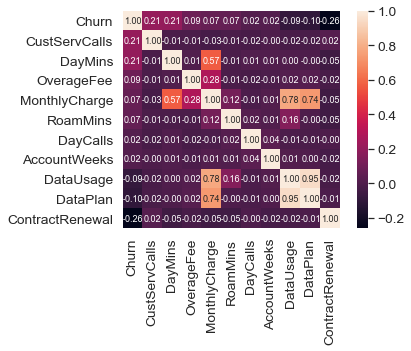

In [7]:
#saleprice correlation matrix
corrmat = df.corr()
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Churn')['Churn'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.savefig('heatmap.png')

In [8]:
# split target and non-target
X = df.drop(columns='Churn')
y = df['Churn']

In [9]:
# test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,stratify = y,random_state = 22)

In [10]:
from imblearn.over_sampling import SMOTE
def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print(len(X_train), len(y_train))

In [11]:
upsample_SMOTE(X_train, y_train, ratio=1.0)

4560 4560


In [12]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

models = []

models.append(("LogisticRegression",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("LinearSVC",LinearSVC()))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))

results = []
names = []
for name,model in models:
    result = cross_val_score(model, X_train, y_train,  cv=3, scoring='roc_auc')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

LogisticRegression 0.8086356387273902
SVC 0.8734070596185229
LinearSVC 0.8106690349602204
KNeighbors 0.8235343062567999
DecisionTree 0.7645603835169319
RandomForest 0.8798618814174487


In [14]:
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')


print('Confusion Matrix')
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print('--- Classification Report ---')
print(classification_report(y_test, rfc_predict))
print('\n')
print('--- All AUC Scores ---')
print(rfc_cv_score)
print('\n')
print('--- Mean AUC Score ---')
print('Mean AUC Score - Random Forest: ', rfc_cv_score.mean())

Confusion Matrix
[[559  11]
 [ 24  73]]


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       570
           1       0.87      0.75      0.81        97

    accuracy                           0.95       667
   macro avg       0.91      0.87      0.89       667
weighted avg       0.95      0.95      0.95       667



--- All AUC Scores ---
[0.90028643 0.9160401  0.88514142 0.85350877 0.93004386 0.91063596
 0.9371345  0.87335526 0.87024854 0.96542398]


--- Mean AUC Score ---
Mean AUC Score - Random Forest:  0.9041818832796278


In [15]:
# Fit kbest to training data to view features by importance
KBest = SelectKBest(score_func = chi2, k=5)
KBest = KBest.fit(X_train,y_train)

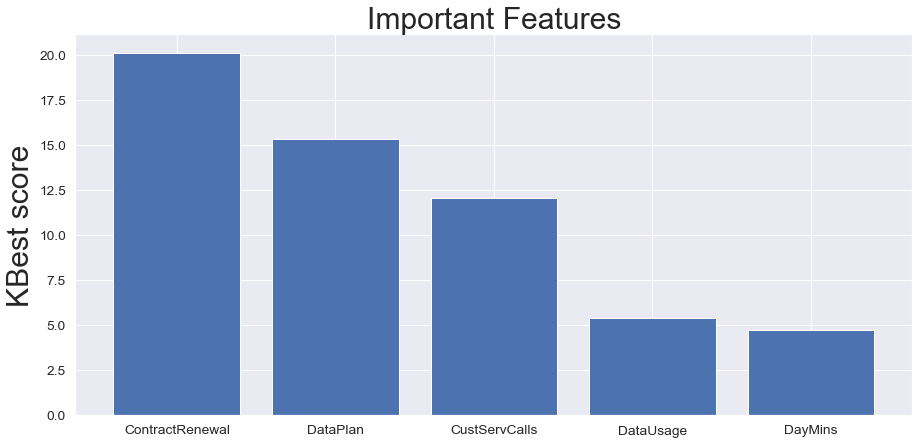

In [16]:
indice = np.argsort(KBest.scores_)[::-1]

# get top 5 feature names
features = []
for i in range(5):
    features.append(X.columns[indice[i]])

    
#plot by Kbest scores
plt.figure(figsize=(15, 7))
plt.bar(features, KBest.scores_[indice[range(5)]])
plt.title('Important Features', fontsize=30)
plt.ylabel('KBest score', fontsize=30)
plt.show()


In [17]:
X_train_chi = KBest.transform(X_train)
X_test_chi = KBest.transform(X_test)

In [18]:
# random forest model on chi2 data
rfc = RandomForestClassifier()
rfc.fit(X_train_chi,y_train)
# predictions
rfc_predict = rfc.predict(X_test_chi)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')


print('Confusion Matrix')
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print('--- Classification Report ---')
print(classification_report(y_test, rfc_predict))
print('\n')
print('--- All AUC Scores ---')
print(rfc_cv_score)
print('\n')
print('--- Mean AUC Score ---')
print('Mean AUC Score - Random Forest: ', rfc_cv_score.mean())

Confusion Matrix
[[531  39]
 [ 36  61]]


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       570
           1       0.61      0.63      0.62        97

    accuracy                           0.89       667
   macro avg       0.77      0.78      0.78       667
weighted avg       0.89      0.89      0.89       667



--- All AUC Scores ---
[0.88893663 0.91757966 0.88342284 0.85394737 0.94780702 0.91107456
 0.93209064 0.87130848 0.88428363 0.96176901]


--- Mean AUC Score ---
Mean AUC Score - Random Forest:  0.9052219835302543


In [19]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [20]:
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3,
                                verbose=1, random_state=42, n_jobs = -1, scoring='recall')
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 59.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 61.3min finished


{'n_estimators': 522, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}


In [27]:
# fine tune model
rfc = RandomForestClassifier(n_estimators=522, min_samples_split=2, min_samples_leaf=2, 
                             max_features='sqrt', max_depth=110, bootstrap=True)
rfc.fit(X_train, y_train)
# predictions
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')


print('Confusion Matrix')
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print('--- Classification Report ---')
print(classification_report(y_test, rfc_predict))
print('\n')
print('--- All AUC Scores ---')
print(rfc_cv_score)
print('\n')
print('--- Mean AUC Score ---')
print('Mean AUC Score - Random Forest: ', rfc_cv_score.mean())

Confusion Matrix
[[564   6]
 [ 26  71]]


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       570
           1       0.92      0.73      0.82        97

    accuracy                           0.95       667
   macro avg       0.94      0.86      0.89       667
weighted avg       0.95      0.95      0.95       667



--- All AUC Scores ---
[0.88779091 0.92860723 0.86913713 0.83464912 0.94312865 0.90628655
 0.92624269 0.8755848  0.88369883 0.96023392]


--- Mean AUC Score ---
Mean AUC Score - Random Forest:  0.9015359828141782


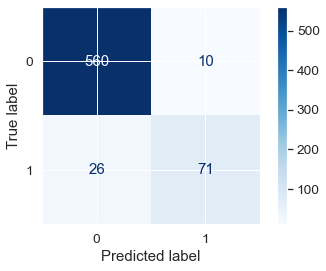

In [24]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rfc, X_test, y_test,
                                 cmap=plt.cm.Blues)